# Graph Memory — Introspection (per-add edges, sim matrix, local subgraph)

In [1]:

# Install deps if missing
import sys, subprocess
def ensure(pkg):
    try: __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
for p in ["numpy", "pandas", "networkx", "matplotlib", "pydantic"]:
    ensure(p)
print("✅ Environment ready")


✅ Environment ready


In [2]:

from pathlib import Path, PurePosixPath
import sys, time
REPO_ROOT = Path.cwd()
def has_required_paths(root: Path) -> bool:
    return (root/"tools/faq_generator/parser.py").exists() and (root/"data/banking_faq_30plus.txt").exists()
cands = [REPO_ROOT] + [p for p in REPO_ROOT.iterdir() if p.is_dir()]
chosen = None
for c in cands:
    if has_required_paths(c): chosen = c.resolve(); break
if chosen is None:
    raise FileNotFoundError("Run from repo root with tools/faq_generator/parser.py and data/banking_faq_30plus.txt")
REPO_ROOT = chosen
if str(REPO_ROOT) not in sys.path: sys.path.append(str(REPO_ROOT))
from graph_mem import GraphMem
try:
    from adapters import faq_ingest_adapter as ingest  # type: ignore
except Exception:
    from adapter import faq_ingest_adapter as ingest  # type: ignore
faq_path = REPO_ROOT/"data/banking_faq_30plus.txt"
TAU, TOPK, ALPHA = 0.35, 5, 0.7
gm = GraphMem(tau=TAU, k=TOPK, alpha=ALPHA)
ids = ingest.ingest_faq_to_graph(str(faq_path), gm)
print("Załadowano faktów:", len(ids))


Załadowano faktów: 32


In [3]:

# Trace edges per add
from tools.faq_generator.parser import FAQParser  # type: ignore

def entry_to_text(entry):
    cat = entry.get("category") or ""
    q = entry.get("question") or ""
    a = entry.get("answer") or ""
    aliases = ", ".join(entry.get("aliases") or [])
    next_steps = "\n".join(f"- {s}" for s in (entry.get("next_steps") or []))
    tags = ", ".join(entry.get("tags") or [])
    blob = "\n".join([
        f"[CATEGORY] {cat}",
        f"Q: {q}",
        f"A: {a}",
        (f"ALIASES: {aliases}" if aliases else ""),
        (f"NEXT_STEPS:\n{next_steps}" if next_steps else ""),
        (f"TAGS: {tags}" if tags else ""),
    ])
    return "\n".join([line for line in blob.splitlines() if line.strip()])

gm_trace = GraphMem(tau=TAU, k=TOPK, alpha=ALPHA)
parser = FAQParser()
entries = parser.parse_file(faq_path)

norm = []
for e in entries:
    if hasattr(e, "model_dump"):
        norm.append(e.model_dump())
    elif isinstance(e, dict):
        norm.append(e)
    else:
        norm.append(e.__dict__)

now = time.time()
MAX_LOG = 20
for i, e in enumerate(norm):
    idx = gm_trace.add(entry_to_text(e), ts=now + i)
    head = (gm_trace.facts[idx].text.splitlines()[0] if gm_trace.facts[idx].text else "")[:140]
    if i < MAX_LOG:
        print(f"\n[ADD] idx={idx}  {head}")
        neigh = gm_trace.facts[idx].neigh
        if not neigh:
            print("  (brak krawędzi — poniżej progu τ)")
        else:
            for (j, w) in neigh:
                head_j = (gm_trace.facts[j].text.splitlines()[0] if gm_trace.facts[j].text else "")[:100]
                print(f"  -> {idx} → {j}  sim={w:.3f}  | {head_j}")
    elif i == MAX_LOG:
        print("\n(…log obcięty — zwiększ MAX_LOG, jeśli chcesz więcej)")
print("\nGotowe. gm_trace zawiera ten sam model co gm, ale dodany w trybie 'trace'.")



[ADD] idx=0  [CATEGORY] chargeback
  (brak krawędzi — poniżej progu τ)

[ADD] idx=1  [CATEGORY] chargeback
  -> 1 → 0  sim=0.907  | [CATEGORY] chargeback

[ADD] idx=2  [CATEGORY] chargeback
  -> 2 → 1  sim=0.828  | [CATEGORY] chargeback
  -> 2 → 0  sim=0.787  | [CATEGORY] chargeback

[ADD] idx=3  [CATEGORY] chargeback
  -> 3 → 1  sim=0.818  | [CATEGORY] chargeback
  -> 3 → 2  sim=0.774  | [CATEGORY] chargeback
  -> 3 → 0  sim=0.772  | [CATEGORY] chargeback

[ADD] idx=4  [CATEGORY] card
  -> 4 → 1  sim=0.745  | [CATEGORY] chargeback
  -> 4 → 3  sim=0.738  | [CATEGORY] chargeback
  -> 4 → 2  sim=0.723  | [CATEGORY] chargeback
  -> 4 → 0  sim=0.705  | [CATEGORY] chargeback

[ADD] idx=5  [CATEGORY] card
  -> 5 → 4  sim=0.834  | [CATEGORY] card
  -> 5 → 1  sim=0.779  | [CATEGORY] chargeback
  -> 5 → 0  sim=0.757  | [CATEGORY] chargeback
  -> 5 → 2  sim=0.748  | [CATEGORY] chargeback
  -> 5 → 3  sim=0.736  | [CATEGORY] chargeback

[ADD] idx=6  [CATEGORY] card
  -> 6 → 5  sim=0.861  | [CATEG

In [4]:

# Mini similarity matrix
import numpy as np, pandas as pd, time
def mini_similarity_matrix(gm, indices):
    labels, vecs = [], []
    for i in indices:
        text = gm.facts[i].text if i < len(gm.facts) else ""
        head = (text.splitlines()[0] if text else f"idx={i}")[:40]
        labels.append(f"{i}: {head}")
        vecs.append(gm.facts[i].vec)
    V = np.vstack(vecs)
    norms = np.linalg.norm(V, axis=1, keepdims=True); norms[norms==0]=1.0
    Vn = V / norms
    M = Vn @ Vn.T
    import pandas as pd
    return pd.DataFrame(M, index=labels, columns=labels)

query = "chargeback dokumenty"
res = gm.retrieve(query, now_ts=time.time(), k=5)
idxs = [gm.facts.index(f) for f in res[:3]] if res else [0,1,2]
df = mini_similarity_matrix(gm, idxs)
df.round(3)


,3: [CATEGORY] chargeback,17: [CATEGORY] account,30: [CATEGORY] loans
3: [CATEGORY] chargeback,1.000,0.689,0.739
17: [CATEGORY] account,0.689,1.000,0.747
30: [CATEGORY] loans,0.739,0.747,1.000


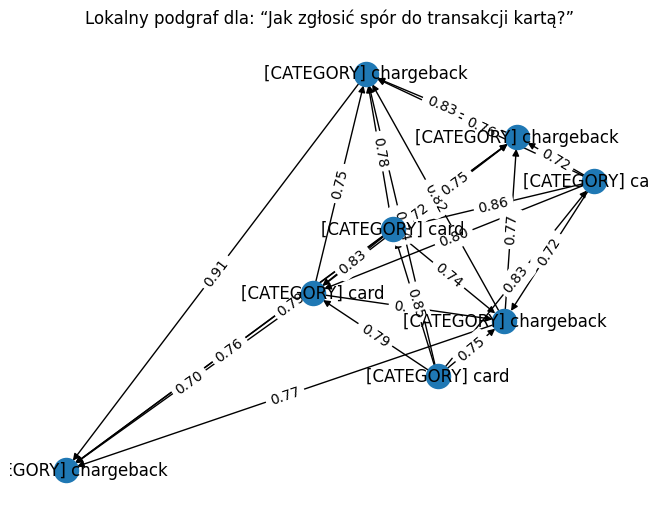

In [5]:

# Draw local subgraph for a query
import networkx as nx, matplotlib.pyplot as plt, time
def draw_local_subgraph(gm, query: str, top_k: int = 4):
    res = gm.retrieve(query, now_ts=time.time(), k=top_k)
    nodes = set()
    for f in res:
        i = gm.facts.index(f)
        nodes.add(i)
        for j, _ in gm.facts[i].neigh:
            nodes.add(j)
    G = nx.DiGraph()
    for i in nodes:
        label = (gm.facts[i].text.splitlines()[0] if gm.facts[i].text else f"idx={i}")[:40]
        G.add_node(i, label=label)
    for i in nodes:
        for j, w in gm.facts[i].neigh:
            if j in nodes:
                G.add_edge(i, j, weight=float(w))
    pos = nx.spring_layout(G, seed=7)
    plt.figure()
    nx.draw(G, pos, with_labels=True, labels={n: G.nodes[n]["label"] for n in G.nodes()})
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f"Lokalny podgraf dla: “{query}”")
    plt.show()

draw_local_subgraph(gm, "Jak zgłosić spór do transakcji kartą?", top_k=4)
